# **Importing data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gdown
import gdown


In [ ]:
# Importing Demographic Data

demo_link = 'https://drive.google.com/file/d/1gsOTrMNuXkb87z7P_As8DF3IeVMvyRe3/view'

demo_path = 'https://drive.google.com/uc?export=download&id=' +demo_link.split("/")[-2]

df_demo = pd.read_csv(demo_path)

# Importing Loan Origin Data

loan_origin_link = 'https://drive.google.com/file/d/1bd45Xmbu2uXp9Q5kbYmpXnulOujtP79J/view'

loan_origin_path = 'https://drive.google.com/uc?export=download&id=' +loan_origin_link.split("/")[-2]

df_loan = pd.read_csv(loan_origin_path)

# Importing final Dataset
repay_link = 'https://drive.google.com/file/d/1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF/view?usp=sharing'

file_id = repay_link.split("/")[-2]

!gdown "https://drive.google.com/uc?export=download&id={file_id}" -O final.csv

df_repayment = pd.read_csv("final.csv")



Downloading...
From (original): https://drive.google.com/uc?export=download&id=1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF
From (redirected): https://drive.google.com/uc?export=download&id=1dhyyDH9c8YNBeH0Q2q5ROZZUKgoDw0nF&confirm=t&uuid=c4e9ca5f-c509-4a8f-ad6f-b967c09fbee2
To: /content/final.csv
100% 249M/249M [00:03<00:00, 66.6MB/s]


# **I. Data Preparation**

## **1. Merge 3 tables**

Note: Because 3 tables have same columns CONTRACT NO which can consider as be primary key, we merge 3 tables for data preparation

### Delete the null in Primary Key in 2 tables




In [ ]:
#delete primary key's null of demo
df_demo = df_demo[df_demo['CONTRACT_NO'].notnull()]

# Check result
print("Total rows after deleting primary key's null of demo:", len(df_demo))

Total rows after deleting primary key's null of demo: 315507


In [ ]:
# Delete primary key's null of loan
df_loan = df_loan[df_loan['CONTRACT_NO'].notnull()]

# Check result
print("Total rows after deleting primary key's null of loan:", len(df_loan))

Total rows after deleting primary key's null of loan: 315643




### We merge 3 tables on CONTRACT_NO

In [ ]:
df_merged = df_demo.merge(df_loan, how='left', on='CONTRACT_NO')

In [ ]:
df_final = df_repayment.merge(df_merged, how = 'inner', on = 'CONTRACT_NO')

In [ ]:
df_merged.shape

(315507, 30)

In [ ]:
df_final['CONTRACT_NO'].value_counts(dropna=False)

,count
CONTRACT_NO,
765326,13
345333,13
357251,13
778163,13
434442,13
...,...
467329,13
467370,13
786262,13


In [ ]:
duplicates_count = df_final.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 0


In [ ]:
df_final['CONTRACT_NO'].value_counts(dropna=False)

,count
CONTRACT_NO,
765326,13
345333,13
357251,13
778163,13
434442,13
...,...
467329,13
467370,13
786262,13


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   CONTRACT_NO                 1313559 non-null  int64  
 1   SYS_RUN_DATE                1313559 non-null  object 
 2   TOTAL_EMI_AMOUNT            1312101 non-null  float64
 3   DUE_DATE_OF_MON             1110520 non-null  object 
 4   PARTNER_CODE                1313559 non-null  int64  
 5   OUTSTANDING                 1313559 non-null  float64
 6   PRI_PAST_DUE                1313559 non-null  float64
 7   INT_PAST_DUE                1313559 non-null  float64
 8   OD_PAST_DUE                 1313559 non-null  float64
 9   OVER_DUE_DAYS_LD            1313559 non-null  float64
 10  OVER_DUE_DAYS_CLIENT        1313559 non-null  float64
 11  LAST_PAYMENT_DATE           1193508 non-null  object 
 12  LAST_PAYMENT_AMOUNT         1193472 non-null  float64
 1

In [ ]:
df_final.shape

(1313559, 46)

##**2. Fix type and format of columns**

###Extract the month and year from DISBURSEMENT_DATE to 2 columns and change types of them to 'float'

In [ ]:
df_final['DISBURSEMENT_DATE'] = pd.to_datetime(df_final['DISBURSEMENT_DATE'], errors='coerce')

# Step 2: Extract the month and year
df_final['month'] = df_final['DISBURSEMENT_DATE'].dt.month.astype(float)  # Extract month and convert to float
df_final['year'] = df_final['DISBURSEMENT_DATE'].dt.year.astype(float)    # Extract year and convert to float



###Change the encode of HAS_INSURANCE: YES to 1, NO to 0

In [ ]:
# Step 1: Replace 'yes' with 1 and 'no' with 0 in the 'HAS_INSURANCE' column
df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].replace({'YES': 1, 'NO': 0})

# Step 2: Convert the 'HAS_INSURANCE' column to float
df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].astype(float)


<ipython-input-14-6ca4ab92c07d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['HAS_INSURANCE'] = df_final['HAS_INSURANCE'].replace({'YES': 1, 'NO': 0})


## **3. Fix NULL of dataset**

Note:
- We use economic and business understanding to fill as much null as we can
- Most of solution is based on using the mode value in each corresponding category
- With null in the columns we have no clue to fill, we use ffill to maintain the Data integrity

### 3.1 Check Correlations of columns in DATESET

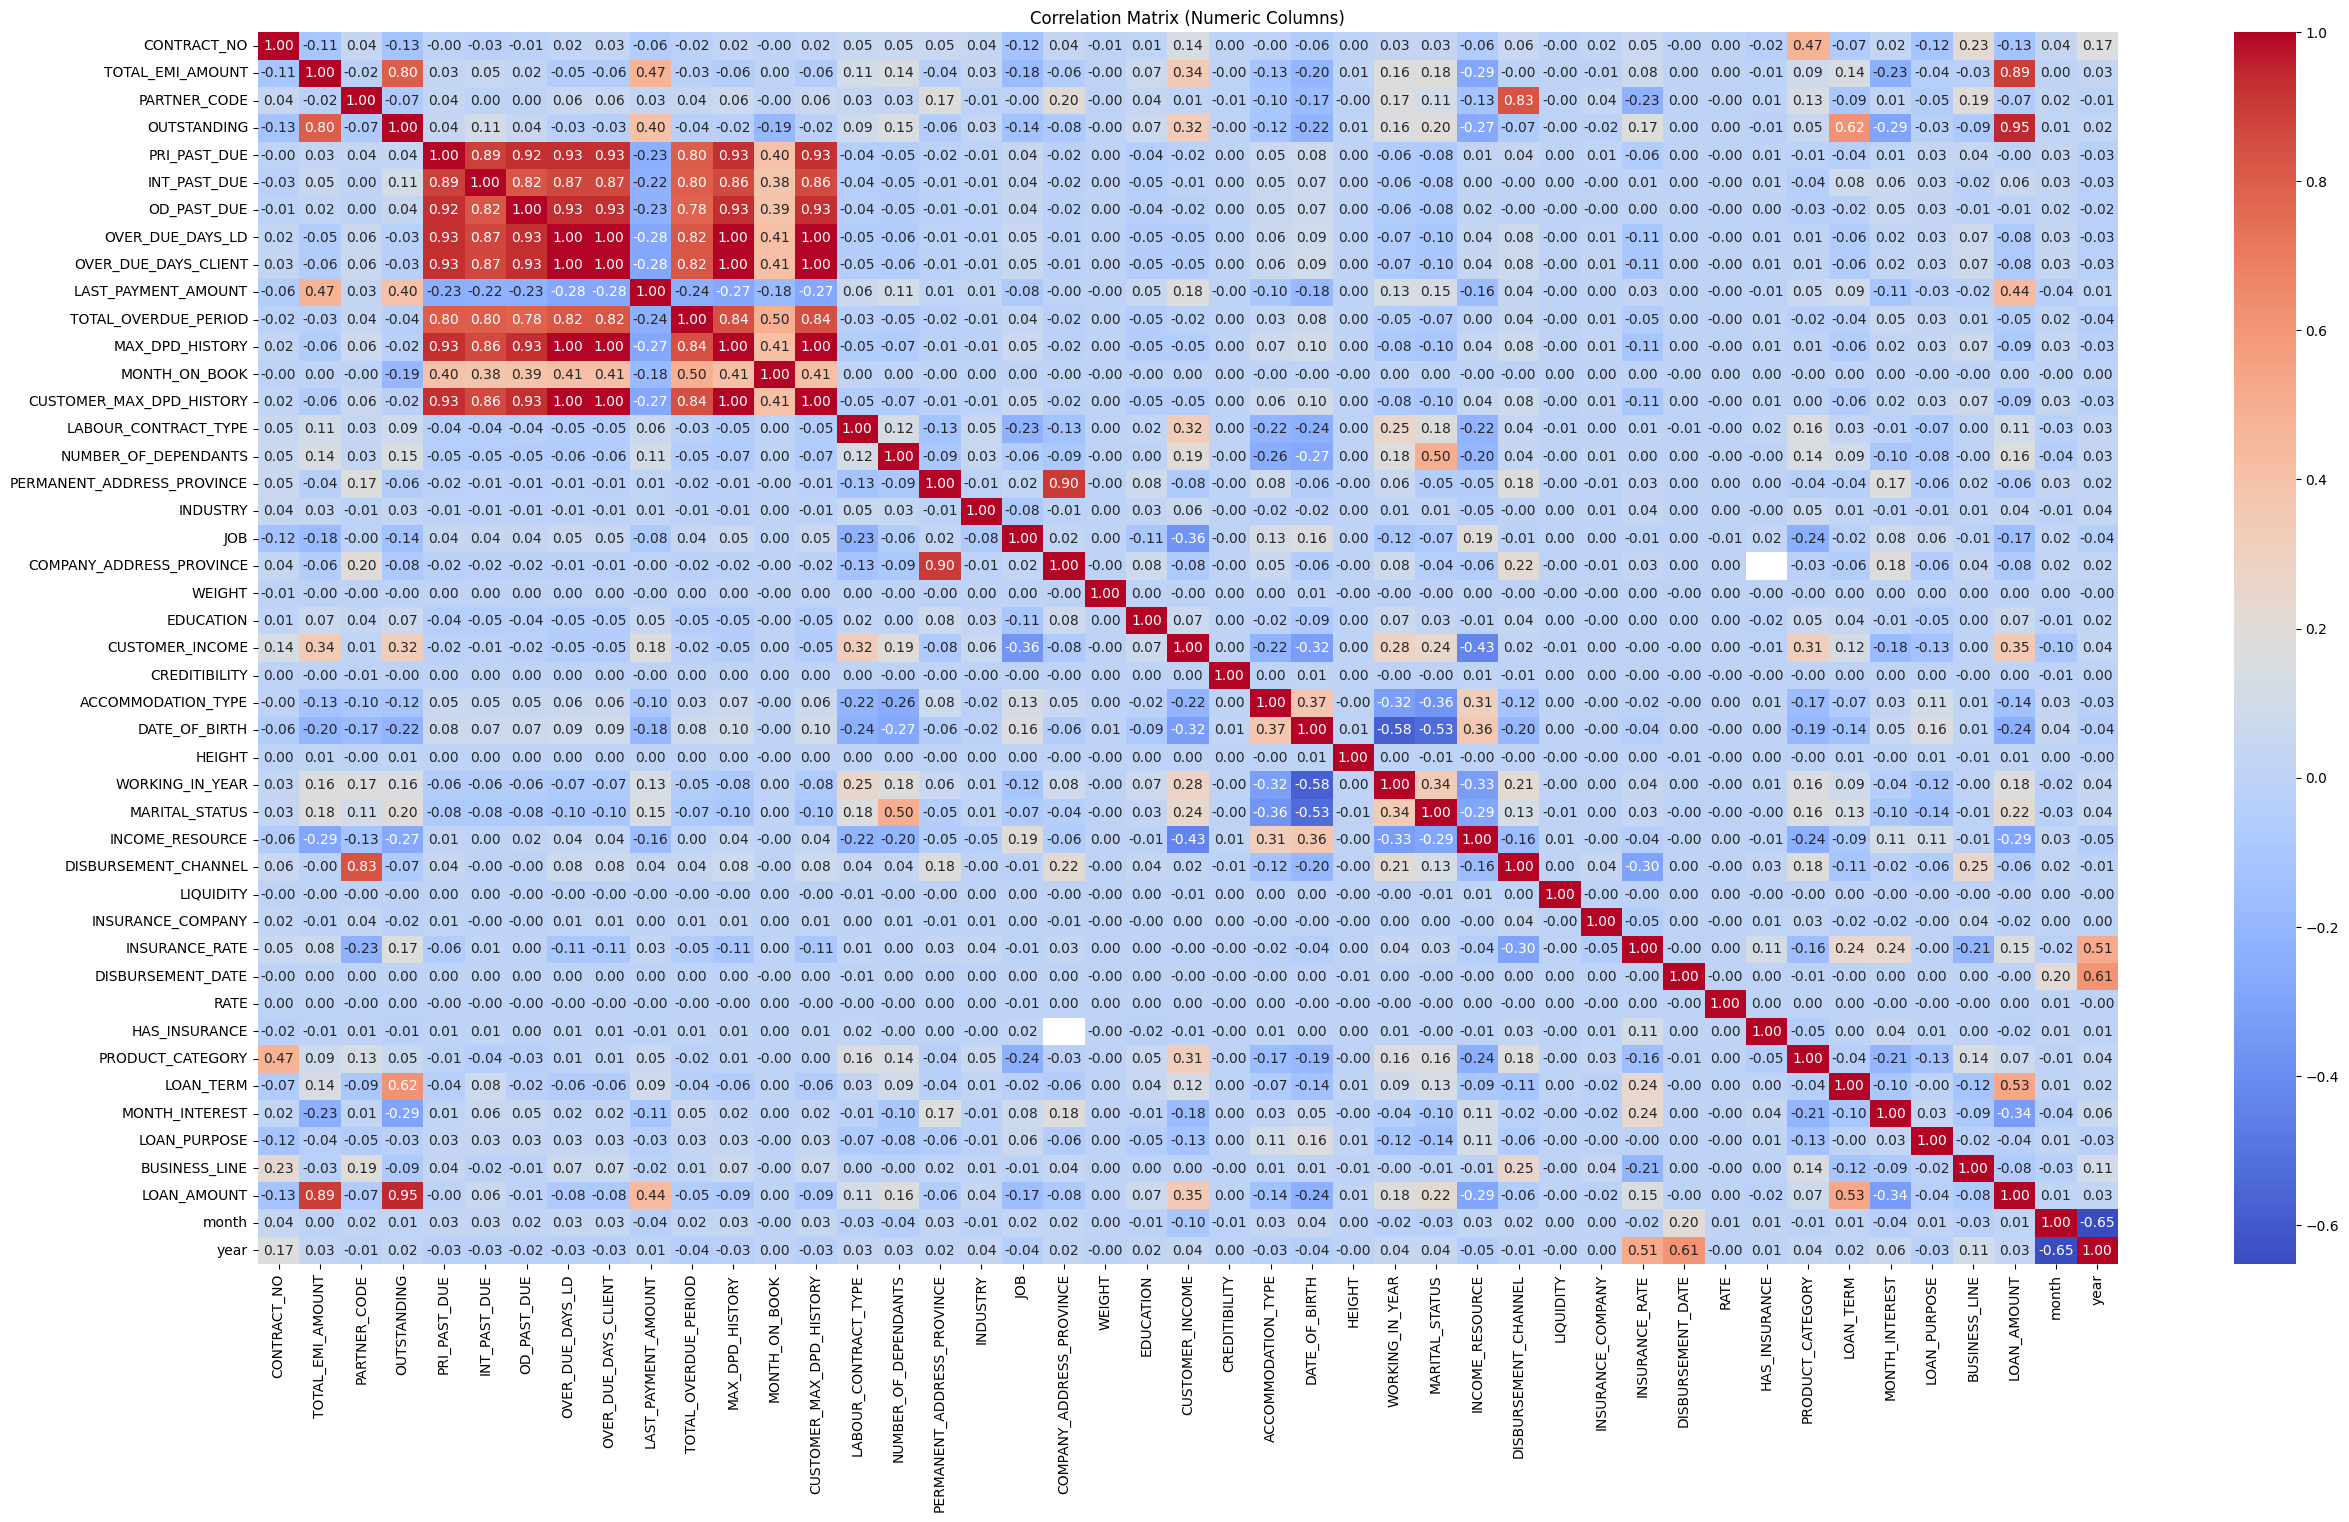

In [ ]:
# Select columns that are not of type 'object'
numeric_columns = df_final.select_dtypes(exclude=['object'])

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(30, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Numeric Columns)")
plt.show()

###3.2 Geographic Information

####PERMANENT_ADDRESS_PROVINCE & COMPANY_ADDRESS_PROVINCE


Note:
- High correlation: 0.86
- People might choose to work in near of their house
- However, there might be some place that does not have company near that

▶ Solution: Fill the null by the mode value of company address in each permanent address and reverse

In [ ]:
# Check the most common "COMPANY_ADDRESS_PROVINCE" for each "PERMANENT_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("PERMANENT_ADDRESS_PROVINCE")["COMPANY_ADDRESS_PROVINCE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()


,COMPANY_ADDRESS_PROVINCE
PERMANENT_ADDRESS_PROVINCE,
1.0,1.0
2.0,27.0
4.0,27.0
6.0,27.0
8.0,26.0


In [ ]:
# Fill missing values in "COMPANY_ADDRESS_PROVINCE" based on the patterns identified with "PERMANENT_ADDRESS_PROVINCE"
print('Before fill', df_final['COMPANY_ADDRESS_PROVINCE'].isnull().sum())
df_final['COMPANY_ADDRESS_PROVINCE'] = df_final.apply(lambda row: province_pattern[row['PERMANENT_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['COMPANY_ADDRESS_PROVINCE']) and row['PERMANENT_ADDRESS_PROVINCE'] in province_pattern
                                              else row['COMPANY_ADDRESS_PROVINCE'], axis=1)
print('After fill', df_final['COMPANY_ADDRESS_PROVINCE'].isnull().sum())

Before fill 404352
After fill 61529


In [ ]:
# Check the most common "PERMANENT_ADDRESS_PROVINCE" for each "COMPANY_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("COMPANY_ADDRESS_PROVINCE")["PERMANENT_ADDRESS_PROVINCE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()

,PERMANENT_ADDRESS_PROVINCE
COMPANY_ADDRESS_PROVINCE,
1.0,1.0
4.0,19.0
6.0,19.0
10.0,25.0
14.0,34.0


In [ ]:
# Fill missing values in "PERMANENT_ADDRESS_PROVINCE based on the patterns identified with ""COMPANY_ADDRESS_PROVINCE"
print('Before fill', df_final['PERMANENT_ADDRESS_PROVINCE'].isnull().sum())
df_final['PERMANENT_ADDRESS_PROVINCE'] = df_final.apply(lambda row: province_pattern[row['COMPANY_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['PERMANENT_ADDRESS_PROVINCE']) and row['COMPANY_ADDRESS_PROVINCE'] in province_pattern
                                              else row['PERMANENT_ADDRESS_PROVINCE'], axis=1)
print('After fill', df_final['PERMANENT_ADDRESS_PROVINCE'].isnull().sum())

Before fill 198042
After fill 61542


####DISBURSEMENT_CHANNEL & COMPANY_ADDRESS_PROVINCE


Note:
- Certain channels may be predominant in specific places
- Company might choose the channel that near their place or they have known before
> Solution: Fill the null by the mode value of DISBURSEMENT_CHANNEL in each COMPANY ADDRESS

In [ ]:
# Check the most common "DISBURSEMENT_CHANNEL" for each "COMPANY_ADDRESS_PROVINCE" to identify patterns
province_pattern = df_final.groupby("COMPANY_ADDRESS_PROVINCE")["DISBURSEMENT_CHANNEL"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
province_pattern.head()


,DISBURSEMENT_CHANNEL
COMPANY_ADDRESS_PROVINCE,
1.0,1.0
4.0,1.0
6.0,1.0
10.0,1.0
14.0,1.0


In [ ]:
# Fill missing values in "DISBURSEMENT_CHANNEL based on the patterns identified with ""COMPANY_ADDRESS_PROVINCE"
print('Before fill', df_final['DISBURSEMENT_CHANNEL'].isnull().sum())
df_final['DISBURSEMENT_CHANNEL'] = df_final.apply(lambda row: province_pattern[row['COMPANY_ADDRESS_PROVINCE']]
                                              if pd.isnull(row['DISBURSEMENT_CHANNEL']) and row['COMPANY_ADDRESS_PROVINCE'] in province_pattern
                                              else row['DISBURSEMENT_CHANNEL'], axis=1)
print('After fill', df_final['DISBURSEMENT_CHANNEL'].isnull().sum())

Before fill 365313
After fill 17160


In [ ]:
df_final.isnull().sum().sort_values(ascending=False)

,0
MONTH_INTEREST,366561
INSURANCE_COMPANY,366184
BUSINESS_LINE,366054
LOAN_TERM,366054
PRODUCT_CATEGORY,365339
HAS_INSURANCE,365300
year,364871
month,364871
DISBURSEMENT_DATE,364871
LIQUIDITY,364442


###3.3 Demographic Information

####DATE_OF_BIRTH and MARITAL_STATUS

Note:
- Older individuals are more likely to be married.
- DATE_OF_BIRTH can be used to infer the probability of being married based on typical age ranges.
>Solution: Fill nulls in MARITAL_STATUS based on the majority marital status in those age groups.

In [ ]:
# Check the most common "MARITAL_STATUS" for each "DATE_OF_BIRTH" to identify patterns
birth_pattern = df_final.groupby("DATE_OF_BIRTH")["MARITAL_STATUS"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
birth_pattern

,MARITAL_STATUS
DATE_OF_BIRTH,
1962.0,2.0
1963.0,2.0
1964.0,2.0
1965.0,2.0
1966.0,2.0
1967.0,2.0
1968.0,2.0
1969.0,2.0
1970.0,2.0


In [ ]:
# Fill missing values in "MARITAL_STATUS based on the patterns identified with ""DATE_OF_BIRTH"
print('Before fill', df_final['MARITAL_STATUS'].isnull().sum())
df_final['MARITAL_STATUS'] = df_final.apply(lambda row: birth_pattern[row['DATE_OF_BIRTH']]
                                              if pd.isnull(row['MARITAL_STATUS']) and row['DATE_OF_BIRTH'] in birth_pattern
                                              else row['MARITAL_STATUS'], axis=1)
print('After fill', df_final['MARITAL_STATUS'].isnull().sum())

Before fill 204932
After fill 29536


####EDUCATION and JOB

Note:
- Higher education levels generally correlate with certain job types
>Use the JOB column to predict EDUCATION level through a frequency-based imputation

In [ ]:
# Check the most common "EDUCATION" for each "JOB" to identify patterns
Job_pattern = df_final.groupby("JOB")["EDUCATION"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Job_pattern

,EDUCATION
JOB,
0.0,1.0
1.0,1.0
2.0,1.0
3.0,NaN
4.0,1.0
5.0,0.0
6.0,1.0
7.0,6.0
8.0,1.0


In [ ]:
# Fill missing values in "EDUCATION based on the patterns identified with ""JOB"
print('Before fill', df_final['EDUCATION'].isnull().sum())
df_final['EDUCATION'] = df_final.apply(lambda row: Job_pattern[row['JOB']]
                                              if pd.isnull(row['EDUCATION']) and row['JOB'] in Job_pattern
                                              else row['EDUCATION'], axis=1)
print('After fill', df_final['EDUCATION'].isnull().sum())

Before fill 202631
After fill 30472


####NUMBER_OF_DEPENDANTS and MARITAL_STATUS

Note:
- Correlation: 0.48
- Married individuals tend to have dependants more often than single individuals.
>Solution: Impute NUMBER_OF_DEPENDANTS by information from MARITAL STATUS

In [ ]:
#Check the information of NUMBER OF DEPENDANTS based on MARITAL STATUS
marital_counts_matrix = df_final.pivot_table(
    index='MARITAL_STATUS',
    columns='NUMBER_OF_DEPENDANTS',
    aggfunc='size',
    fill_value=0
)

#Show result
marital_counts_matrix

NUMBER_OF_DEPENDANTS,0.0,1.0,2.0,3.0,4.0,5.0,6.0,10.0,20.0
MARITAL_STATUS,,,,,,,,,
0.0,399451,10855,3952,442,65,26,0,13,0
1.0,43849,28132,11973,1391,143,39,0,0,0
2.0,195078,163553,147680,33956,4693,559,26,0,13
3.0,11427,6968,4056,741,13,0,0,0,0
4.0,8177,2782,1846,260,52,26,0,0,0


82765 People with status 0.0 have number_of_dependants equal to 0 => Fill all rows with nod null and ms = 0 to 0

In [ ]:
#Fill null in NUMBER_OF_DEPENDANTS to 0 of people with status 0.0
print('Before fix: ', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum() )
df_final.loc[(df_final['MARITAL_STATUS'] == 0) & (df_final['NUMBER_OF_DEPENDANTS'].isnull()), 'NUMBER_OF_DEPENDANTS'] = 0
print('After fix: ', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum() )

Before fix:  206986
After fix:  129233



Nearly 100% of people with status 1.0,  3.0, 4.0 have mode number of dependants is 0 => fill these status with 0. The number of dependants in marital status = 2.0 mostly on 0-2, however we dont have evidence to fill this status

In [ ]:
# Print the number of nulls before filling
print('Before fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())

# Fill nulls with 0 where the marital status is 1, 3, or 4
df_final.loc[df_final['MARITAL_STATUS'].isin([1, 3, 4]) & df_final['NUMBER_OF_DEPENDANTS'].isnull(), 'NUMBER_OF_DEPENDANTS'] = 0

# Print the number of nulls after filling
print('After fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())

Before fill: 129233
After fill: 107744


#### Number of Depedants from Date of birth, marital status and customer income


Note:
- We have already known most of number of dependants in data set is zero in every type of marital status
- People with low age might have less number of dependants
- Customer income might affect the number of dependants

In [ ]:
Birth_pattern = df_final.groupby("DATE_OF_BIRTH")["NUMBER_OF_DEPENDANTS"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Birth_pattern

,NUMBER_OF_DEPENDANTS
DATE_OF_BIRTH,
1962.0,0.0
1963.0,0.0
1964.0,0.0
1965.0,0.0
1966.0,0.0
1967.0,0.0
1968.0,0.0
1969.0,0.0
1970.0,0.0


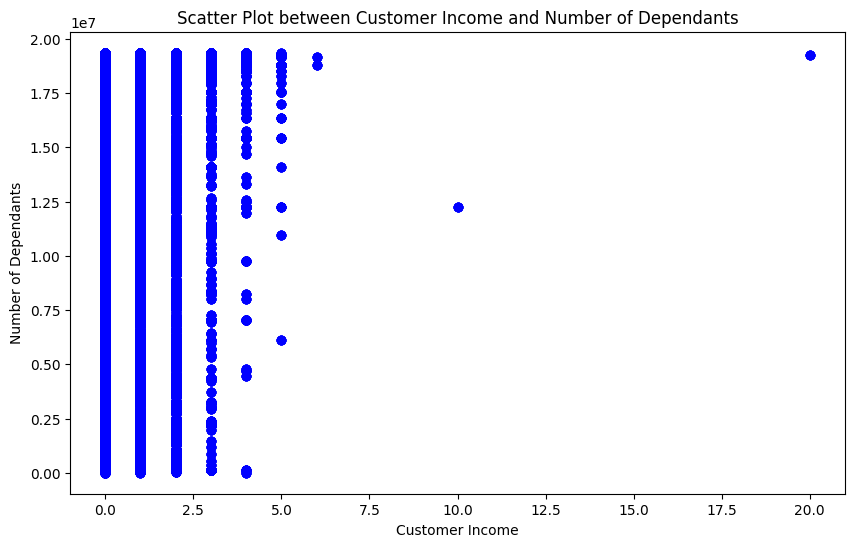

In [ ]:
# Drop rows with nulls in CUSTOMER_INCOME or NUMBER_OF_DEPENDANTS for visualization purposes
df_cleaned = df_final.dropna(subset=['CUSTOMER_INCOME', 'NUMBER_OF_DEPENDANTS'])

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y = df_cleaned['CUSTOMER_INCOME'],x = df_cleaned['NUMBER_OF_DEPENDANTS'], alpha=0.5, color='blue')

# Set plot title and labels
plt.title('Scatter Plot between Customer Income and Number of Dependants')
plt.xlabel('Customer Income')
plt.ylabel('Number of Dependants')

# Display the plot
plt.show()

So now we know in every category 0 still be the mode of number of dependants
>Solution: Fill null of number of dependants with 0

In [ ]:
# Điền giá trị 0 vào các ô null trong cột NUMBER_OF_DEPENDANTS
df_final['NUMBER_OF_DEPENDANTS'].fillna(0, inplace=True)

# Kiểm tra lại số lượng null sau khi điền
print('After fill:', df_final['NUMBER_OF_DEPENDANTS'].isnull().sum())


After fill: 0


<ipython-input-32-a5da09f42dac>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['NUMBER_OF_DEPENDANTS'].fillna(0, inplace=True)


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 48 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   CONTRACT_NO                 1313559 non-null  int64         
 1   SYS_RUN_DATE                1313559 non-null  object        
 2   TOTAL_EMI_AMOUNT            1312101 non-null  float64       
 3   DUE_DATE_OF_MON             1110520 non-null  object        
 4   PARTNER_CODE                1313559 non-null  int64         
 5   OUTSTANDING                 1313559 non-null  float64       
 6   PRI_PAST_DUE                1313559 non-null  float64       
 7   INT_PAST_DUE                1313559 non-null  float64       
 8   OD_PAST_DUE                 1313559 non-null  float64       
 9   OVER_DUE_DAYS_LD            1313559 non-null  float64       
 10  OVER_DUE_DAYS_CLIENT        1313559 non-null  float64       
 11  LAST_PAYMENT_DATE       

###3.4 Loan and Financial Information

####CUSTOMER INCOME

Note:
We believe the factor affect customer income includes "INCOME_RESOURCE", "JOB" and "ACCOMMODATION_TYPE" with INCOME_RESOURCE > JOB > ACCOMMODATION_TYPE.
>So we decide to fill null in CUSTOMER_INCOME by information from 3 category
and sort by influent extent

In [ ]:
income_pattern = df_final.groupby("INCOME_RESOURCE")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['INCOME_RESOURCE']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['INCOME_RESOURCE'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 196456
After fill 29666


In [ ]:
income_pattern = df_final.groupby("JOB")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['JOB']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['JOB'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 29666
After fill 4550


In [ ]:
income_pattern = df_final.groupby("ACCOMMODATION_TYPE")["CUSTOMER_INCOME"].agg(lambda x: x.mean() if not x.empty else None)
income_pattern
print('Before fill', df_final['CUSTOMER_INCOME'].isnull().sum())
df_final['CUSTOMER_INCOME'] = df_final.apply(lambda row: income_pattern[row['ACCOMMODATION_TYPE']]
                                              if pd.isnull(row['CUSTOMER_INCOME']) and row['ACCOMMODATION_TYPE'] in income_pattern
                                              else row['CUSTOMER_INCOME'], axis=1)
print('After fill', df_final['CUSTOMER_INCOME'].isnull().sum())

Before fill 4550
After fill 780


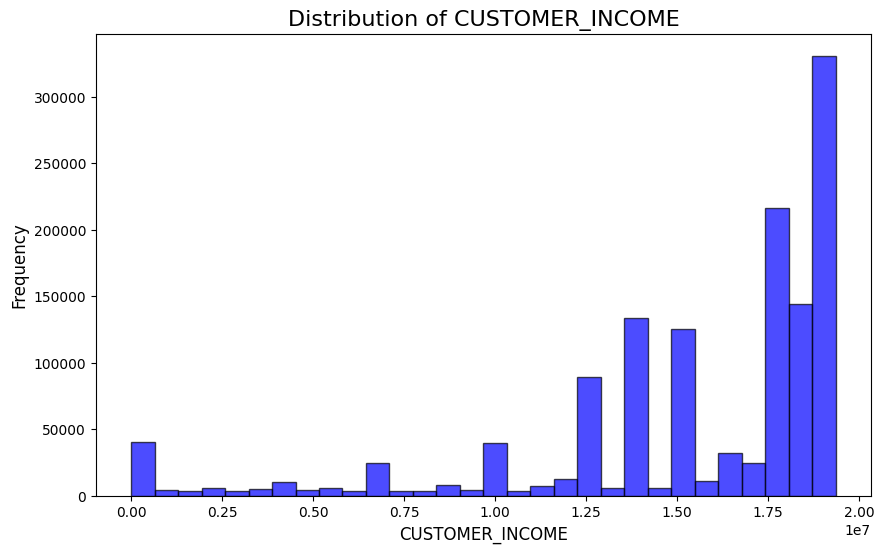

In [ ]:
#Draw the customer income distribution
plt.figure(figsize=(10, 6))

# Draw the histogram
plt.hist(df_final['CUSTOMER_INCOME'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of CUSTOMER_INCOME', fontsize=16)
plt.xlabel('CUSTOMER_INCOME', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


In [ ]:
df = df_final.copy()

In [ ]:
df_final = df.copy()

####LOAN_AMOUNT

Note:
* Customer income might decide the loan_amount because
  * Lenders assess a customer's income to evaluate their capacity to repay the loan
  * Debt-to-Income Ratio (DTI)
* Loan Purpose will also affect the loan_amount, for instance, the house loan might be higher than a car loan
* Loan Term is also a factor help determined the loan amount, higher loan term might go with higher loan amount. However the effect of this can not be equal with 2 above factors

In [ ]:
print('Before Fill: ', df_final['LOAN_AMOUNT'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df_final['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# # Grouping to see the most common "CUSTOMER_INCOME" values within each "LOAN_AMOUNT" category
LOAN_AMOUNT_pattern = df_final.groupby("CUSTOMER_INCOME")["LOAN_AMOUNT"].agg(lambda x: x.mean() if not x.empty else None)
LOAN_AMOUNT_pattern
# Fill missing values in "CUSTOMER_INCOME" based on the patterns identified with "LOAN_AMOUNT"
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: LOAN_AMOUNT_pattern[row['CUSTOMER_INCOME']]
                                         if pd.isnull(row['LOAN_AMOUNT']) and row['CUSTOMER_INCOME'] in LOAN_AMOUNT_pattern
                                         else row['LOAN_AMOUNT'], axis=1)
print('After Fill: ', df_final['LOAN_AMOUNT'].isnull().sum())

Before Fill:  363116
After Fill:  22308


In [ ]:
income_pattern = df_final.groupby("LOAN_PURPOSE")["LOAN_AMOUNT"].agg(lambda x: x.mode() if not x.empty else None)
income_pattern
print('Before fill', df_final['LOAN_AMOUNT'].isnull().sum())
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: income_pattern[row['LOAN_PURPOSE']]
                                              if pd.isnull(row['LOAN_AMOUNT']) and row['LOAN_PURPOSE'] in income_pattern
                                              else row['LOAN_AMOUNT'], axis=1)
print('After fill', df_final['LOAN_AMOUNT'].isnull().sum())

Before fill 22308
After fill 13871


In [ ]:
income_pattern = df_final.groupby("LOAN_TERM")["LOAN_AMOUNT"].agg(lambda x: x.mode() if not x.empty else None)
income_pattern
print('Before fill', df_final['LOAN_AMOUNT'].isnull().sum())
df_final['LOAN_AMOUNT'] = df_final.apply(lambda row: income_pattern[row['LOAN_TERM']]
                                              if pd.isnull(row['LOAN_AMOUNT']) and row['LOAN_TERM'] in income_pattern
                                              else row['LOAN_AMOUNT'], axis=1)
print('After fill', df_final['LOAN_AMOUNT'].isnull().sum())

Before fill 13871
After fill 12753


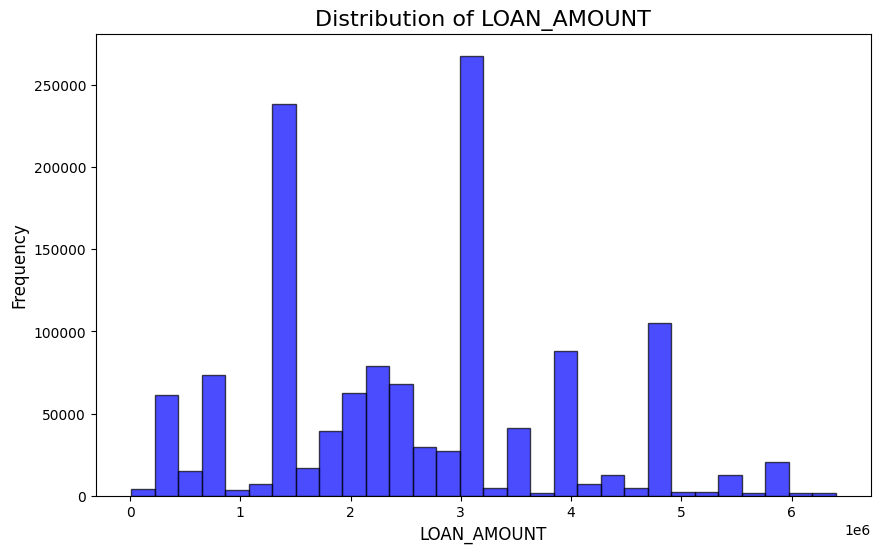

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_final['LOAN_AMOUNT'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of LOAN_AMOUNT', fontsize=16)
plt.xlabel('LOAN_AMOUNT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

####Loan Amount and Loan Term

Note:
- Correlation 0,62
- Large loan amount might go with long term loan
> Solution: Use loan amount to predict long term information

In [ ]:
print('Before Fill: ', df_final['LOAN_TERM'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['LOAN_AMOUNT_BIN'] = pd.qcut(df_final['LOAN_AMOUNT'], q=12, labels=False, duplicates="drop")

# Grouping to see the most common "LOAN_AMOUNT_BIN" values within each "LOAN_TERM" category
Loan_Term_pattern = df_final.groupby("LOAN_AMOUNT_BIN")["LOAN_TERM"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern
# Fill missing values in "LOAN_AMOUNT_BIN" based on the patterns identified with "LOAN_TERM"
df_final['LOAN_TERM'] = df_final.apply(lambda row: Loan_Term_pattern[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['LOAN_TERM']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern
                                         else row['LOAN_TERM'], axis=1)
print('After Fill: ', df_final['LOAN_TERM'].isnull().sum())

Before Fill:  366054
After Fill:  12753


####LOAN_TERM & MONTH_INTEREST

Note:
- Loan term will affect the month_interest, with longer term, interest will be higer
> FIll null of long_term by month_interest

In [ ]:
print('Before Fill: ', df_final['LOAN_TERM'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("MONTH_INTEREST")["LOAN_TERM"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['LOAN_TERM'] = df_final.apply(lambda row: Loan_Term_pattern1[row['MONTH_INTEREST']]
                                         if pd.isnull(row['LOAN_TERM']) and row['MONTH_INTEREST'] in Loan_Term_pattern1
                                         else row['LOAN_TERM'], axis=1)
print('After Fill: ', df_final['LOAN_TERM'].isnull().sum())

Before Fill:  12753
After Fill:  12519


####LOAN_AMOUNT AND LOAN_PURPOSE

*Note
- As loan purpose is one of the factor to decide loan amount, we can predict the null of loan purpose by using loan amount

In [ ]:
print('Before Fill: ', df_final['LOAN_PURPOSE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("LOAN_AMOUNT_BIN")["LOAN_PURPOSE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['LOAN_PURPOSE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['LOAN_PURPOSE']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern1
                                         else row['LOAN_PURPOSE'], axis=1)
print('After Fill: ', df_final['LOAN_PURPOSE'].isnull().sum())

Before Fill:  362739
After Fill:  12753


####LOAN_AMOUNT and PRODUCT_CATEGORY

Note:
- Certain products are tied to specific loan amount
>If PRODUCT_CATEGORY is missing, impute based on the common combinations observed for each Loan_amount. Conversely, use PRODUCT_CATEGORY to predict missing LOAN_AMOUNT.

In [ ]:
print('Before Fill: ', df_final['PRODUCT_CATEGORY'].isnull().sum())
# Divide the LOAN_AMOUNT column into 12 equal intervals and create a new column
df_final['LOAN_AMOUNT_BIN'] = pd.qcut(df_final['LOAN_AMOUNT'], q=12, labels=False, duplicates="drop")

# Grouping to see the most common "PRODUCT_CATEGORY" values within each "LOAN_AMOUNT" category
LOAN_AMOUNT_pattern = df_final.groupby("LOAN_AMOUNT_BIN")["PRODUCT_CATEGORY"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
LOAN_AMOUNT_pattern
# Fill missing values in "PRODUCT_CATEGORY" based on the patterns identified with "LOAN_AMOUNT"
df_final['PRODUCT_CATEGORY'] = df_final.apply(lambda row: LOAN_AMOUNT_pattern[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['PRODUCT_CATEGORY']) and row['LOAN_AMOUNT_BIN'] in LOAN_AMOUNT_pattern
                                         else row['PRODUCT_CATEGORY'], axis=1)
print('After Fill: ', df_final['PRODUCT_CATEGORY'].isnull().sum())

Before Fill:  365339
After Fill:  12558


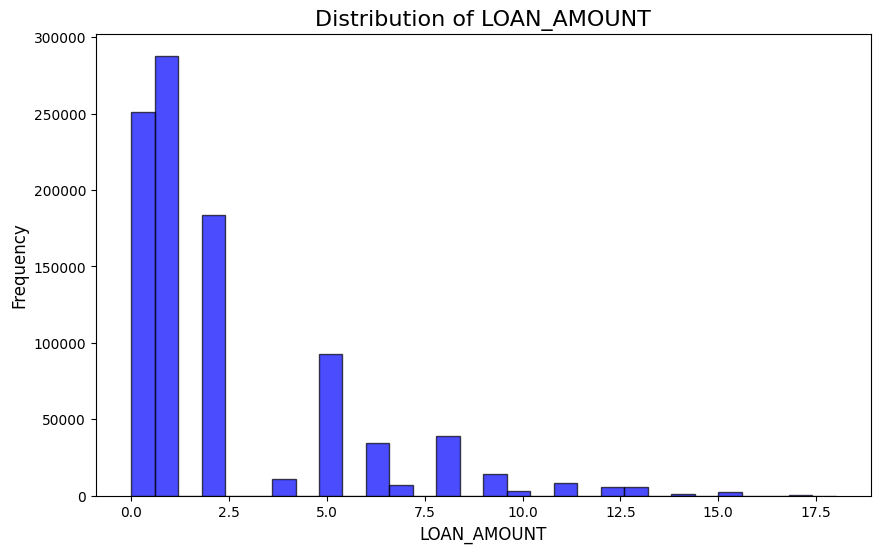

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(df['PRODUCT_CATEGORY'], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of LOAN_AMOUNT', fontsize=16)
plt.xlabel('LOAN_AMOUNT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

####CUSTOMER_INCOME & INCOME_RESOUCES

Note:
- As INCOME_RESOURCES is one of the factor to determine customer_income, we can use customer income to predict income_resource

In [ ]:
# Print the count of null values before filling
print('Before Fill: ', df_final['INCOME_RESOURCE'].isnull().sum())

# Create bins for CUSTOMER_INCOME
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# Grouping to find the most common INCOME_RESOURCE value for each CUSTOMER_INCOME group
LOAN_AMOUNT_pattern = df_final.groupby("CUSTOMER_INCOME")["INCOME_RESOURCE"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Apply the pattern to fill missing values in "INCOME_RESOURCE"
df_final['INCOME_RESOURCE'] = df_final.apply(
    lambda row: LOAN_AMOUNT_pattern[row['CUSTOMER_INCOME']]
    if pd.isnull(row['INCOME_RESOURCE']) and row['CUSTOMER_INCOME'] in LOAN_AMOUNT_pattern
    else row['INCOME_RESOURCE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['INCOME_RESOURCE'].isnull().sum())


Before Fill:  203684
After Fill:  42146


####ACCOMODATION_TYPE and CUSTOMER INCOME

Note:
- People with higher income might live in different accommodation type with lower one

In [ ]:
# Print the count of null values before filling
print('Before Fill: ', df_final['ACCOMMODATION_TYPE'].isnull().sum())

# Create bins for CUSTOMER_INCOME
df_final['CUSTOMER_INCOME_BIN'] = pd.qcut(df_final['CUSTOMER_INCOME'], q=12, labels=False, duplicates='drop')

# Grouping to find the most common JOB value for each CUSTOMER_INCOME group
JOB_pattern = df_final.groupby("CUSTOMER_INCOME")["ACCOMMODATION_TYPE"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Apply the pattern to fill missing values in "JOB"
df_final['ACCOMMODATION_TYPE'] = df_final.apply(
    lambda row: JOB_pattern[row['CUSTOMER_INCOME']]
    if pd.isnull(row['ACCOMMODATION_TYPE']) and row['CUSTOMER_INCOME'] in JOB_pattern
    else row['ACCOMMODATION_TYPE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['ACCOMMODATION_TYPE'].isnull().sum())



Before Fill:  205491
After Fill:  13377


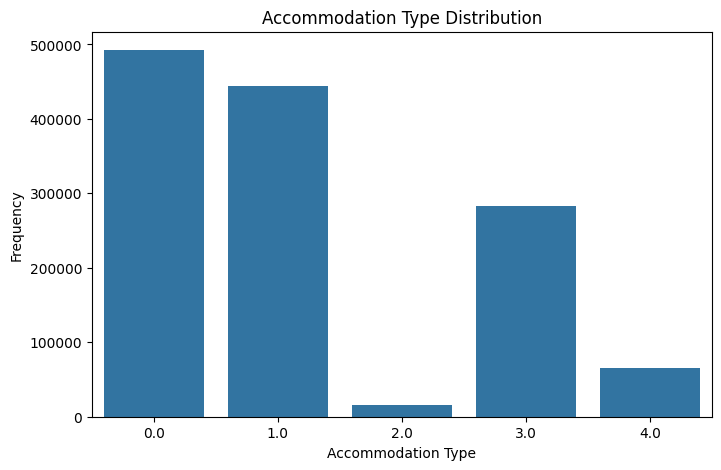

In [ ]:
# Accommodation Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='ACCOMMODATION_TYPE', data=df_final)
plt.title("Accommodation Type Distribution")
plt.xlabel("Accommodation Type")
plt.ylabel("Frequency")
plt.show()

Note:
- It is clear that more year of experiences might go with higher income
>So we use customer income to predict the working in year

####LOAN PURPOSE AND MONTH_INTEREST

Note:
- Loan purpose decides the amount of month_interest
  - Different Purposes, Different Risks: Lenders evaluate the risk associated with the purpose of a loan.
  - Business Loans vs. Personal Loans
> Predict month_interest by loan_Purpose

In [ ]:
loan_pattern = df_final.groupby("LOAN_PURPOSE")["MONTH_INTEREST"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
loan_pattern
print('Before fill', df_final['MONTH_INTEREST'].isnull().sum())
df_final['MONTH_INTEREST'] = df_final.apply(lambda row: loan_pattern[row['LOAN_PURPOSE']]
                                              if pd.isnull(row['MONTH_INTEREST']) and row['LOAN_PURPOSE'] in loan_pattern
                                              else row['MONTH_INTEREST'], axis=1)
print('After fill', df_final['MONTH_INTEREST'].isnull().sum())

Before fill 366561
After fill 12519


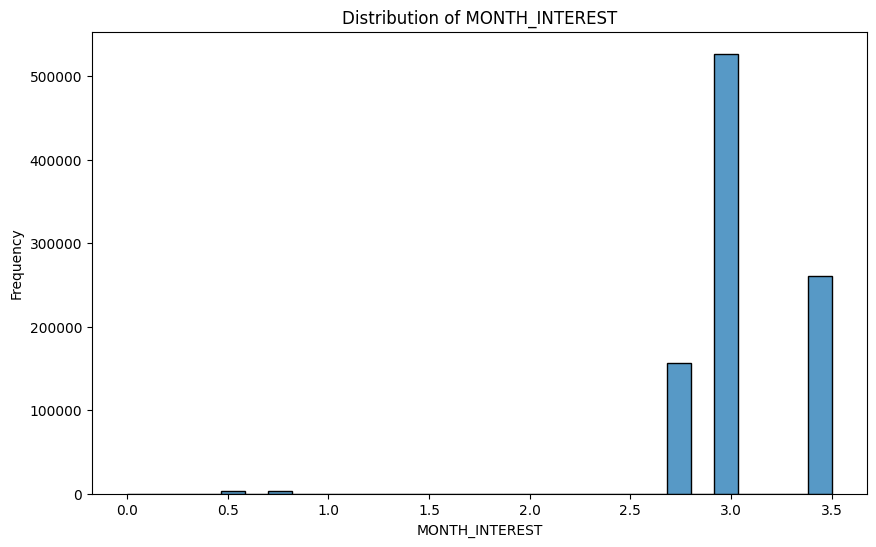

In [ ]:
# Assuming df is your DataFrame
plt.figure(figsize=(10,6))  # Optional: Change the size of the plot

# Plot the distribution of 'MONTH_INTEREST' column
sns.histplot(df_final['INSURANCE_RATE'], kde=False, bins=30)

# Add labels and title
plt.title('Distribution of MONTH_INTEREST')
plt.xlabel('MONTH_INTEREST')
plt.ylabel('Frequency')

# Show the plot
plt.show()


####Loan Amount and Business Line

Note:
Loan amount can determine the business line because
- Industry Risk Profile: High-risk industries may face smaller loan amounts due to higher chances of default.
- Revenue Stability: Consistent revenue in stable industries can lead to larger approved loan amounts.
- Collateral Availability: Asset-rich businesses can secure larger loans with valuable collateral.

In [ ]:
print('Before Fill: ', df_final['BUSINESS_LINE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("LOAN_AMOUNT_BIN")["BUSINESS_LINE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['BUSINESS_LINE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['LOAN_AMOUNT_BIN']]
                                         if pd.isnull(row['BUSINESS_LINE']) and row['LOAN_AMOUNT_BIN'] in Loan_Term_pattern1
                                         else row['BUSINESS_LINE'], axis=1)
print('After Fill: ', df_final['BUSINESS_LINE'].isnull().sum())

Before Fill:  366054
After Fill:  12519


### **3.5 INSURANCE**

####INSURANCE_COMPANY and INSURANCE_RATE

Note:
- Insurance companies usually come with their own insurance rates, the larger insurance companies usually have lower insurance rates.
> Predict null of insurance rate by insurance comapny and reverse

In [ ]:
print('Before Fill: ', df_final['INSURANCE_RATE'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("INSURANCE_COMPANY")["INSURANCE_RATE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['INSURANCE_RATE'] = df_final.apply(lambda row: Loan_Term_pattern1[row['INSURANCE_COMPANY']]
                                         if pd.isnull(row['INSURANCE_RATE']) and row['INSURANCE_COMPANY'] in Loan_Term_pattern1
                                         else row['INSURANCE_RATE'], axis=1)
print('After Fill: ', df_final['INSURANCE_RATE'].isnull().sum())

Before Fill:  363766
After Fill:  221806


In [ ]:
print('Before Fill: ', df_final['INSURANCE_COMPANY'].isnull().sum())
# Grouping to see the most common "JOB" values within each "INDUSTRY" category
Loan_Term_pattern1 = df_final.groupby("INSURANCE_RATE")["INSURANCE_COMPANY"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
Loan_Term_pattern1
# Fill missing values in "JOB" based on the patterns identified with "INDUSTRY"
df_final['INSURANCE_COMPANY'] = df_final.apply(lambda row: Loan_Term_pattern1[row['INSURANCE_RATE']]
                                         if pd.isnull(row['INSURANCE_COMPANY']) and row['INSURANCE_RATE'] in Loan_Term_pattern1
                                         else row['INSURANCE_COMPANY'], axis=1)
print('After Fill: ', df_final['INSURANCE_COMPANY'].isnull().sum())

Before Fill:  366184
After Fill:  221806


#### Has Insurance with insurance rate

In [ ]:
# Fill null values in HAS_INSURANCE with 0 if INSURANCE_RATE is 0
df_final['HAS_INSURANCE'] = df_final.apply(
    lambda row: 0 if pd.isnull(row['HAS_INSURANCE']) and row['INSURANCE_RATE'] == 0 else row['HAS_INSURANCE'],
    axis=1
)

# Print the count of null values after filling
print('After Fill: ', df_final['HAS_INSURANCE'].isnull().sum())

After Fill:  365287


In [ ]:
# Fill null values in HAS_INSURANCE with 1
df_final['HAS_INSURANCE'].fillna(1, inplace=True)

# Print the count of null values after filling
print('After Fill: ', df_final['HAS_INSURANCE'].isnull().sum())

After Fill:  0


<ipython-input-58-619418ab21e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['HAS_INSURANCE'].fillna(1, inplace=True)


####DISBURSEMENT and INSURANCE RATE

Note:
Data show that the Insurance rate has risen through 2 years show that we can predict the Disburment date by using the insurance rate information

In [ ]:
marital_pattern = df_final.groupby("INSURANCE_RATE")["DISBURSEMENT_DATE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
marital_pattern
print('Before fill', df_final['DISBURSEMENT_DATE'].isnull().sum())
df_final['DISBURSEMENT_DATE'] = df_final.apply(lambda row: marital_pattern[row['INSURANCE_RATE']]
                                              if pd.isnull(row['DISBURSEMENT_DATE']) and row['INSURANCE_RATE'] in marital_pattern
                                              else row['DISBURSEMENT_DATE'], axis=1)
print('After fill', df_final['DISBURSEMENT_DATE'].isnull().sum())

Before fill 364871
After fill 200655


###**3.6 OTHER RELATIONSHIP**

####LABOUR CONTRACT_TYPE AND JOB

Note:
- Some specific job require specific labour_contract_type

In [ ]:
# Fill missing values in "LABOUR_CONTRACT_TYPE based on the patterns identified with ""JOB"
marital_pattern = df_final.groupby("JOB")["LABOUR_CONTRACT_TYPE"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
marital_pattern
print('Before fill', df_final['LABOUR_CONTRACT_TYPE'].isnull().sum())
df_final['LABOUR_CONTRACT_TYPE'] = df_final.apply(lambda row: marital_pattern[row['JOB']]
                                              if pd.isnull(row['LABOUR_CONTRACT_TYPE']) and row['JOB'] in marital_pattern
                                              else row['LABOUR_CONTRACT_TYPE'], axis=1)
print('After fill', df_final['LABOUR_CONTRACT_TYPE'].isnull().sum())

Before fill 259766
After fill 40859


####Adjust month and year column by new disbursement date

In [ ]:
df_final.drop(['month', 'year'], axis = 1, inplace = True)
df_final['DISBURSEMENT_DATE'] = pd.to_datetime(df_final['DISBURSEMENT_DATE'], errors='coerce')

# Step 2: Extract the month and year
df_final['month'] = df_final['DISBURSEMENT_DATE'].dt.month.astype(float)  # Extract month and convert to float
df_final['year'] = df_final['DISBURSEMENT_DATE'].dt.year.astype(float)    # Extract year and convert to float


###**3.7 FFILL all null without clues**

Note:
With other columns, we dont have clue to fill their null, so we decide to use ffill to preserve the data interity

In [ ]:
df = df_final.copy()
df.fillna(method='ffill', inplace=True)

# Hiển thị kết quả
df.isnull().sum()

<ipython-input-62-afe289383d9e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,0
CONTRACT_NO,0
SYS_RUN_DATE,0
TOTAL_EMI_AMOUNT,0
DUE_DATE_OF_MON,1
PARTNER_CODE,0
OUTSTANDING,0
PRI_PAST_DUE,0
INT_PAST_DUE,0
OD_PAST_DUE,0
OVER_DUE_DAYS_LD,0


In [ ]:
# Fill nulls in the JOB column with the mode of df_final
df['JOB'].fillna(df_final['JOB'].mode()[0], inplace=True)

# Fill nulls in the WEIGHT column with the mode of df_final
df['WEIGHT'].fillna(df_final['WEIGHT'].mode()[0], inplace=True)

df['EDUCATION'].fillna(df_final['EDUCATION'].mode()[0], inplace=True)
df['HEIGHT'].fillna(df_final['HEIGHT'].mode()[0], inplace=True)

<ipython-input-63-a49654d5a58c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['JOB'].fillna(df_final['JOB'].mode()[0], inplace=True)
<ipython-input-63-a49654d5a58c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
df_loan_demo = df.copy()

JOB and weight still have null, we fill by using mode

Xoá các cột không còn cần thiết

## **4. REPAYMENT**

In [ ]:

df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT)
)


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'], errors='coerce')
df['SYS_RUN_DATE'] = df['SYS_RUN_DATE'].dt.strftime('%Y-%m')

In [ ]:
# Fill in null in the TOTAL_EMI_AMOUNT column (all records with the same contract_no have the same TOTAL_EMI_AMOUNT )
df['TOTAL_EMI_AMOUNT'] = df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


<ipython-input-67-d8439fa9becc>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['TOTAL_EMI_AMOUNT'] = df.groupby('CONTRACT_NO')['TOTAL_EMI_AMOUNT'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [ ]:
# Fill null in the CUSTOMER_MAX_DPD_HISTORY column with 0
df['CUSTOMER_MAX_DPD_HISTORY'] = df['CUSTOMER_MAX_DPD_HISTORY'].fillna(0)

In [ ]:
# The following columns are also filled with 0
df['TOTAL_OVERDUE_PERIOD'] = df['TOTAL_OVERDUE_PERIOD'].fillna(0)
df['MAX_DPD_HISTORY'] = df['MAX_DPD_HISTORY'].fillna(0)
df['LAST_PAYMENT_AMOUNT'] = df['LAST_PAYMENT_AMOUNT'].fillna(0)

In [ ]:
# Check and fill null values for 'LAST_PAYMENT_DATE'
def fill_last_payment_date(row):
    if pd.isna(row['LAST_PAYMENT_DATE']):  # Process only when LAST_PAYMENT_DATE is null
        if row['OVER_DUE_DAYS_LD'] == 0.0:
            # If OVER_DUE_DAYS_LD == 0.0, then LAST_PAYMENT_DATE = DUE_DATE_OF_MON - 1 day
            return row['DUE_DATE_OF_MON'] - pd.Timedelta(days=1)
        elif row['OVER_DUE_DAYS_LD'] > 0.0:
            # If OVER_DUE_DAYS_LD > 0.0, then LAST_PAYMENT_DATE = DUE_DATE_OF_MON - OVER_DUE_DAYS_LD - 3 days
            return row['DUE_DATE_OF_MON'] - pd.Timedelta(days=row['OVER_DUE_DAYS_LD'] + 3)
    return row['LAST_PAYMENT_DATE']

# Apply the function to the entire dataframe
df['LAST_PAYMENT_DATE'] = df.apply(fill_last_payment_date, axis=1)

# Check and print rows where 'LAST_PAYMENT_DATE' is still NaT
null_last_payment_date = df[df['LAST_PAYMENT_DATE'].isna()]
first_row_df_final = df_final.iloc[0]
common_columns = df.columns.intersection(df.columns)
df.loc[0, common_columns] = first_row_df_final[common_columns].values



In [ ]:
!pip install lunarcalendar
import pandas as pd
from lunarcalendar import Converter, Solar, Lunar



In [ ]:
# Fill null in columns 'JOB', 'EDUCATION', 'HEIGHT' with their respective mode
for col in ['JOB', 'EDUCATION', 'HEIGHT']:
    mode_value = df[col].mode().iloc[0]
    df[col].fillna(mode_value, inplace=True)


<ipython-input-72-cef2036811aa>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Điền giá trị null của DUE_DATE_OF_MON bằng ngày gần nhất của tháng và năm từ SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')

# Thêm cột ngày trong tuần (được mã hóa từ Monday = 1 đến Sunday = 7)
df['WEEKDAY'] = df['DUE_DATE_OF_MON'].dt.weekday + 1


# Thêm cột ngày âm lịch
def convert_to_lunar(date):
    solar = Solar(date.year, date.month, date.day)
    lunar = Converter.Solar2Lunar(solar)
    return f"{lunar.year}-{lunar.month}-{lunar.day}"

df['LUNAR_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['WEEKDAY'] = df.groupby('CONTRACT_NO')['WEEKDAY'].transform(lambda x: [0] + list(x.iloc[1:]))

In [ ]:
df['WEEKDAY'] = df.groupby('CONTRACT_NO')['WEEKDAY'].transform(lambda x: [0] + list(x.iloc[1:]))

In [ ]:
total_outstanding = df['OUTSTANDING'].sum()
print(total_outstanding)

3792407389.2131557


In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE']).dt.date

In [ ]:
total_penalty = df['OD_PAST_DUE'].sum()
print(total_penalty)

145175128.77556103


In [ ]:
result = df.groupby('CONTRACT_NO').apply(lambda x: (x['OD_PAST_DUE'] > 0).sum()).reset_index(name='Penalty_Count')
count_greater_than_zero = (result['Penalty_Count'] > 0).sum()
number_of_contracts=df['CONTRACT_NO'].nunique()
percent=(count_greater_than_zero/number_of_contracts)*100
print(f"{percent:.2f}%")

45.44%


<ipython-input-78-261fcb8d8202>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('CONTRACT_NO').apply(lambda x: (x['OD_PAST_DUE'] > 0).sum()).reset_index(name='Penalty_Count')


## **5. Drop unnecessary columns**

In [ ]:
df.drop(['LOAN_AMOUNT_BIN', 'CUSTOMER_INCOME_BIN','DISBURSEMENT_DATE'], axis =1 , inplace = True )

## **6. Create Columns**

###ADD BUCKETS

In [ ]:
# Redefine the DPD bucket classification function, as the environment has reset
def classify_dpd_bucket(days_overdue):
    if days_overdue == 0:
        return "B0"
    elif 1 <= days_overdue <= 9:
        return "B1"
    elif 10 <= days_overdue <= 30:
        return "B2"
    elif 31 <= days_overdue <= 60:
        return "B3"
    elif 61 <= days_overdue <= 90:
        return "B4"
    elif 91 <= days_overdue <= 120:
        return "B5"
    elif 121 <= days_overdue <= 150:
        return "B6"
    elif 151 <= days_overdue <= 180:
        return "B7"
    elif 181 <= days_overdue <= 210:
        return "B8"
    elif 211 <= days_overdue <= 240:
        return "B9"
    elif 241 <= days_overdue <= 270:
        return "B10"
    elif 181 <= days_overdue <= 210:
        return "B11"
    elif 211 <= days_overdue <= 240:
        return "B12"
    elif 241 <= days_overdue <= 270:
        return "B13"
    else:
        return "B14"
# Apply the DPD bucket classification function to the new data
df['DPD_BUCKET'] = df['OVER_DUE_DAYS_LD'].apply(classify_dpd_bucket)

### Calculate Age

In [ ]:
df['Age'] = 2024 - df['DATE_OF_BIRTH']

### Extract number from DPD Bucket

In [ ]:
# Tạo một cột mới chỉ chứa phần số từ cột DPD_BUCKET
df['BUCKET_NUMBER'] = df['DPD_BUCKET'].str.extract('(\d+)', expand=False).astype(int)

### Calculate Weekday, Lunar day, 1-3 day of lunar day of Due date and Payment Date

In [ ]:
!pip install lunarcalendar

import pandas as pd
from lunarcalendar import Converter, Solar, Lunar

In [ ]:
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])
df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
nearest_day = df['DUE_DATE_OF_MON'].dropna().dt.day.min()

# Fill the null value of DUE_DATE_OF_MON with the nearest day of the month and year from SYS_RUN_DATE
df['DUE_DATE_OF_MON'] = df['DUE_DATE_OF_MON'].fillna(
    df['SYS_RUN_DATE'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=nearest_day)if pd.notnull(x) else pd.NaT))

df['DUE_DATE_OF_MON'] = pd.to_datetime(df['DUE_DATE_OF_MON'], errors='coerce')
df['LAST_PAYMENT_DATE'] = pd.to_datetime(df['LAST_PAYMENT_DATE'], errors='coerce')

# Add weekday column (Monday = 1, Sunday = 7)
df['WEEKDAY_DUE_DATE'] = df['DUE_DATE_OF_MON'].dt.weekday + 1
df['WEEKDAY_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].dt.weekday + 1

# Function to convert Gregorian date to Lunar date
def convert_to_lunar(date):
    try:
        solar = Solar(date.year, date.month, date.day)  # Create a Solar object
        lunar = Converter.Solar2Lunar(solar)  # Convert Solar to Lunar
        return f"{lunar.year}-{lunar.month}-{lunar.day}"  # Return formatted Lunar date
    except:
        return None  # Return None for invalid dates

# Add Lunar Date column
df['LUNAR_DATE_DUE_DATE'] = df['DUE_DATE_OF_MON'].apply(convert_to_lunar)
df['LUNAR_DATE_PAYMENT_DATE'] = df['LAST_PAYMENT_DATE'].apply(convert_to_lunar)

# Adjust WEEKDAY for CONTRACT_NO groups (add 0 for the first row of each group)
def adjust_weekday(series):
    return [0] + list(series.iloc[1:].values)

df['WEEKDAY_DUE_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_DUE_DATE'].transform(adjust_weekday)
df['WEEKDAY_PAYMENT_DATE'] = df.groupby('CONTRACT_NO')['WEEKDAY_PAYMENT_DATE'].transform(adjust_weekday)

In [ ]:
# Function to check if a Lunar Date falls on the 1st or 2nd or 3rd day of the lunar month
def is_lunar_1_or_2_or_3_day(lunar_date):
    try:
        if lunar_date:
            lunar_day = int(lunar_date.split('-')[2])  # Extract the day part of Lunar Date
            return lunar_day in [1, 2, 3]  # Check if it's the 1st or 2nd day
        return False
    except:
        return False

# Add a new column to indicate if DUE_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_DUE_DATE'] = df['LUNAR_DATE_DUE_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)

# Add a new column to indicate if PAYMENT_DATE is Lunar 1st or 2nd
df['IS_LUNAR_1-3_DAY_PAYMENT_DATE'] = df['LUNAR_DATE_PAYMENT_DATE'].apply(is_lunar_1_or_2_or_3_day).astype(int)


In [ ]:
df[['IS_LUNAR_1-3_DAY_DUE_DATE', 'IS_LUNAR_1-3_DAY_PAYMENT_DATE', 'BUCKET_NUMBER']][(df['IS_LUNAR_1-3_DAY_DUE_DATE'] == 1) & (df['BUCKET_NUMBER'] == 1)]


,IS_LUNAR_1-3_DAY_DUE_DATE,IS_LUNAR_1-3_DAY_PAYMENT_DATE,BUCKET_NUMBER
4779,1,0,1
5206,1,0,1
5752,1,0,1
5960,1,0,1
6441,1,1,1
...,...,...,...
1312343,1,1,1
1312732,1,0,1
1313056,1,0,1
1313135,1,0,1
